In [1]:
import os
import sys
from collections import OrderedDict, defaultdict

import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.gridspec import GridSpec
from scipy import stats
from scipy.io import mmread, mmwrite
from scipy.sparse import csr_matrix
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import normalize, scale

# from synchromesh.scripts.utils import read_str_list, sanitize_mtx, norm, do_pf, do_log_pf
# from synchromesh.scripts.plot import  plot_depth_norm, plot_depth_dist, plot_knee, plot_pc_depth, plot_mean_var, plot_monotone, plot_example_gene


def nd(arr):
    return np.asarray(arr).reshape(-1)


def yex(ax):
    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
        np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
    ]

    # now plot both limits against eachother
    ax.plot(lims, lims, "k-", alpha=0.75, zorder=0)
    ax.set_aspect("equal")
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    return ax


fsize = 15

base_figure_path = "figures"


alpha = 0.33

import matplotlib

matplotlib.rcParams["mathtext.fontset"] = "cm"
matplotlib.rcParams["font.family"] = "STIXGeneral"
matplotlib.rcParams["font.size"] = fsize
%config InlineBackend.figure_format = 'retina'

In [2]:
cividis = matplotlib.cm.get_cmap("cividis")
colors = {"cell": cividis(0.01), "gene": cividis(0.5), "mono": cividis(0.99)}

In [59]:
mtx_labels = [
    "raw",
    "pf",
    "log",
    "pf_log",
    "pf_log_pf",
    "cpm_log",
    "cp10k_log",
    "sqrt",
    "sctransform_cc",
]
# labels = ['raw', 'pf', "sqrt", 'log', 'cp10k_log', 'cpm_log', 'cp10k_log_scale', 'sctransform', 'pf_log', 'pf_log_pf']
labels = [
    "raw",
    "PF",
    "sqrt",
    "log1p",
    "log1pCP10k",
    "log1pCPM",
    "scalelog1pCP10k",
    "sctransform",
    "log1pPF",
    "PFlog1pPF",
    "log1pPFsctransform_cc",
]
txlabel = {
    "raw": "raw",
    "pf": "PF",
    "sqrt": "sqrt",
    "log": "log1p",
    "cp10k_log": "log1pCP10k",
    "cpm_log": "log1pCPM",
    "cp10k_log_scale": "scalelog1pCP10k",
    "sctransform": "sctransform",
    "pf_log": "log1pPF",
    "pf_log_pf": "PFlog1pPF",
    "sctransform_cc": "log1pPFsctransform_cc",
}


def read_data(base_data_fn):
    data = {}

    for title in mtx_labels:
        print(f"loading {title}")
        in_fn = os.path.join(base_data_fn, f"{title}.mtx.gz")
        data[txlabel[title]] = mmread(in_fn).toarray()

    title = "sctransform"
    print(f"loading {title}")
    in_fn = os.path.join(base_data_fn, f"{title}.csv.gz")
    data[txlabel[title]] = pd.read_csv(in_fn, header=None).values

    title = "cp10k_log_scale"
    print(f"loading {title}")
    in_fn = os.path.join(base_data_fn, f"{title}.csv.gz")
    data[txlabel[title]] = pd.read_csv(in_fn, header=None).values
    return data

In [4]:
ds = "angelidis_2019"
out_prefix = os.path.join("synchromesh/data/", ds, "corrected_counts")

In [5]:
%%time
data = read_data(out_prefix)

loading raw
loading pf
loading log
loading pf_log
loading pf_log_pf
loading cpm_log
loading cp10k_log
loading sqrt
loading sctransform_cc
loading sctransform
loading cp10k_log_scale
CPU times: user 12min 9s, sys: 23.2 s, total: 12min 33s
Wall time: 12min 30s


In [48]:
pf = data["sctransform_cc"].sum(1).mean()

new_sct_cc = np.log1p(normalize(data["sctransform_cc"], norm="l1")*pf)

data["sctransform_cc"] = new_sct_cc

In [49]:
bcs = pd.read_csv(
    os.path.join(out_prefix, "metadata_barcodes.txt.gz"),
    compression="gzip",
    index_col=0,
)
assignments = bcs.celltype.values

genes = pd.read_csv(
    os.path.join(out_prefix, "raw_genes.txt.gz"), compression="gzip", header=None
).values.ravel()

In [50]:
# cell types

celltypes = ["Type_2_pneumocytes", "Alveolar_macrophage", "Ciliated_cells"]
ct_masks = [assignments == i for i in celltypes]

In [51]:
ct = celltypes[0]
ct_mask = ct_masks[0]

In [52]:
ct

'Type_2_pneumocytes'

# Pc and depth

In [53]:
%%time
# ## data for pc
pc_comps = {}
pc_fit = {}
for title, matrix in data.items():
    print(title)
    pca = PCA(n_components=1, svd_solver="full")
    Y = pca.fit_transform(matrix[ct_mask])
    pc_comps[title] = pca.components_
    pc_fit[title] = Y

raw
PF
log1p
log1pPF
PFlog1pPF
log1pCPM
log1pCP10k
sqrt
sctransform_cc
sctransform
scalelog1pCP10k
CPU times: user 4h 41min 41s, sys: 1h 21min 23s, total: 6h 3min 5s
Wall time: 8min 8s


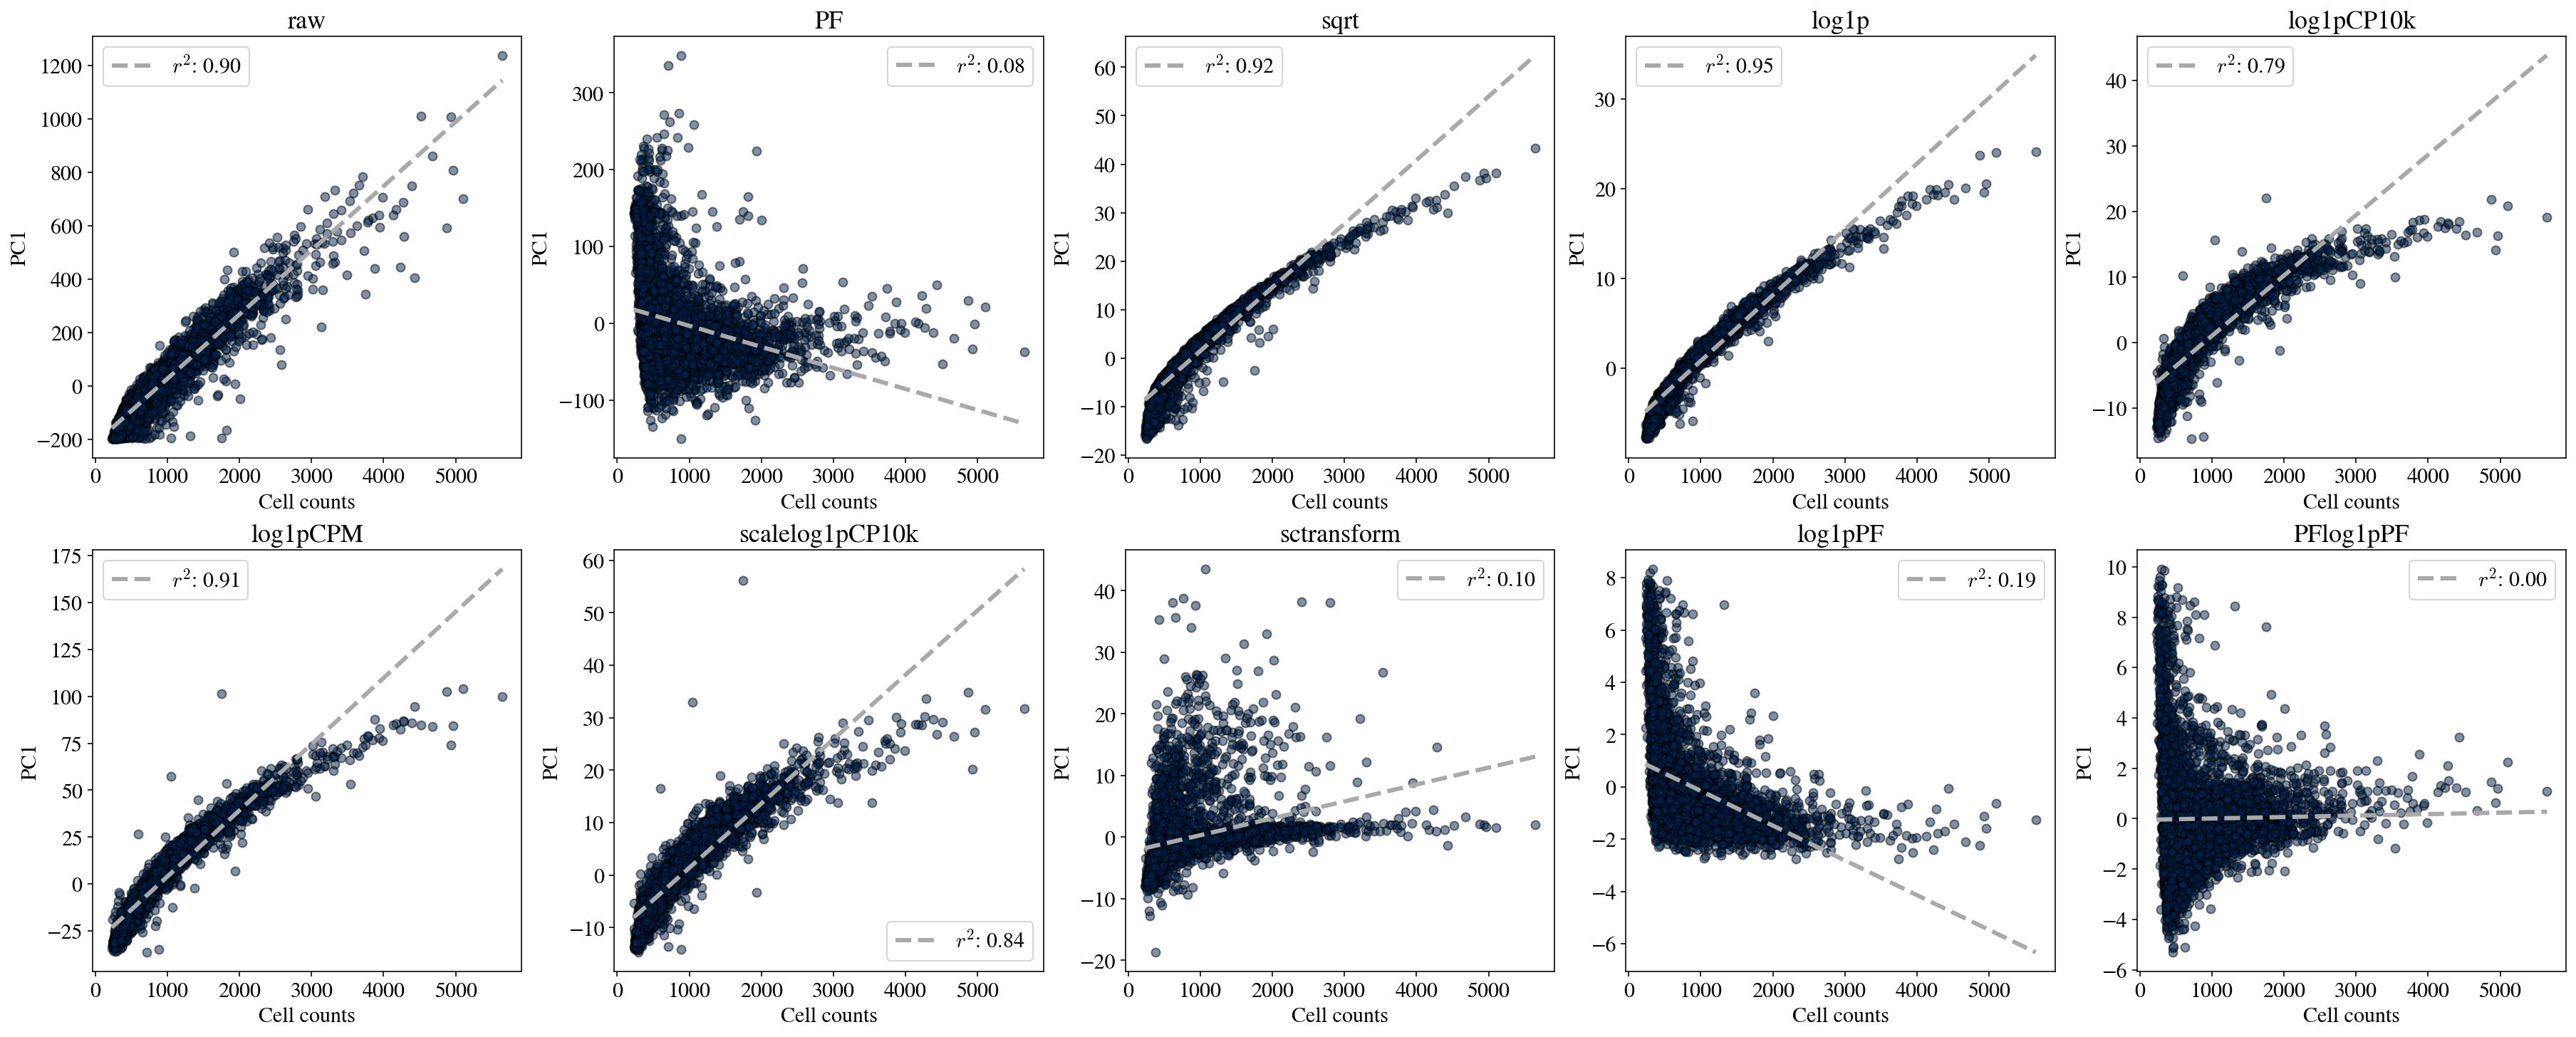

In [15]:
nr = 2
nc = 5
fig, ax = plt.subplots(
    figsize=(5 * nc, 5 * nr), nrows=nr, ncols=nc, constrained_layout=True
)

for ax in fig.axes[10:]:
    ax.remove()

for ax, l in zip(fig.axes, labels):
    x = data["raw"][ct_mask].sum(1)
    y = pc_fit[l].flatten()

    ax.scatter(x, y, facecolor=colors["cell"], edgecolor="k", alpha=0.5)

    reg = LinearRegression().fit(x.reshape(-1, 1), y)
    r2 = reg.score(x.reshape(-1, 1), y)
    xx = np.array([min(x), max(x)])
    ax.plot(
        xx,
        reg.coef_ * xx + reg.intercept_,
        color="darkgray",
        linestyle="--",
        linewidth=3,
        label=f"$r^2$: {r2:,.2f}",
    )

    ax.set(**{"xlabel": "Cell counts", "ylabel": "PC1", "title": l})
    ax.legend()


base_file_name = "angelidis_2019-pc1_celldepth-scatter"
save_path = os.path.join(base_figure_path, base_file_name)
if not os.path.exists(save_path):
    os.makedirs(save_path)

fig.savefig(
    os.path.join(save_path, f"{base_file_name}.png"),
    facecolor="white",
    transparent=False,
    dpi=300,
    bbox_inches="tight",
)
fig.savefig(
    os.path.join(save_path, f"{base_file_name}.pdf"), dpi=300, bbox_inches="tight"
)

fig.show()

In [16]:
data["raw"].sum(1).mean()

818.4679673259974

In [67]:
pc_corr = {}
for l in labels:
    x = data["raw"][ct_mask].sum(1)
    y = pc_fit[l].flatten()

    reg = LinearRegression().fit(x.reshape(-1, 1), y)
    r2 = reg.score(x.reshape(-1, 1), y)
    pc_corr[l] = np.sqrt(r2)
    ct_metrics[l]["r2_pc1"] = r2

In [68]:
pc_corr

{'raw': 0.9483328544311689,
 'PF': 0.27964825713609126,
 'sqrt': 0.956752817038806,
 'log1p': 0.9728982018776006,
 'log1pCP10k': 0.8863924097060173,
 'log1pCPM': 0.953570780922637,
 'scalelog1pCP10k': 0.9178558534563225,
 'sctransform': 0.3136447322331838,
 'log1pPF': 0.430801946271371,
 'PFlog1pPF': 0.01582051661615991,
 'sctransform_cc': 0.28739935895618035}

/home/sina/bin/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  if sys.path[0] == '':


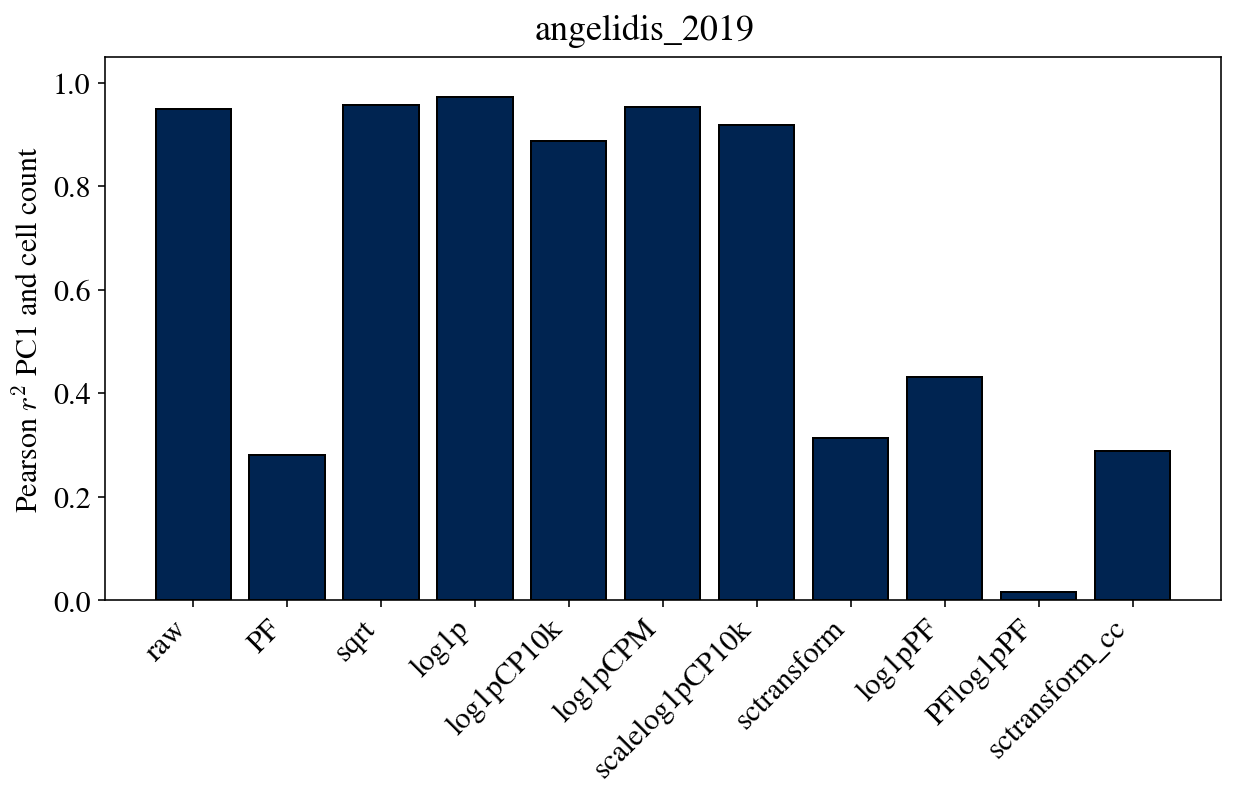

In [18]:
fig, ax = plt.subplots(figsize=(10, 5))
fig.suptitle(ds, y=0.94)

x = [k for k, _ in pc_corr.items()]
y = [v for k, v in pc_corr.items()]
ax.bar(x, y, facecolor=colors["cell"], edgecolor="k")
ax.set(**{"ylabel": "Pearson $r^2$ PC1 and cell count", "ylim": (0, 1.05)})

ax.set_xticklabels(x, ha="right", rotation=45)


base_file_name = "angelidis_2019-pc1_celldepth_r2-bar"
save_path = os.path.join(base_figure_path, base_file_name)
if not os.path.exists(save_path):
    os.makedirs(save_path)

fig.savefig(
    os.path.join(save_path, f"{base_file_name}.png"),
    facecolor="white",
    transparent=False,
    dpi=300,
    bbox_inches="tight",
)
fig.savefig(
    os.path.join(save_path, f"{base_file_name}.pdf"), dpi=300, bbox_inches="tight"
)

fig.show()

# Cell depth and clustering

In [19]:
from sklearn.metrics import pairwise_distances

In [20]:
n = 1000
sample_cells = np.random.choice(ct_mask.sum(), 1000, replace=False)
depth = pairwise_distances(
    data["raw"][ct_mask][sample_cells].sum(1).reshape(-1, 1), metric="l1"
)
depth = depth[np.triu_indices(depth.shape[0], k=1)]

In [21]:
%%time
dist = {}
for l in labels:
    print(l)
    pw = pairwise_distances(data[l][ct_mask][sample_cells], metric="l1")
    v = pw[np.triu_indices(pw.shape[0], k=1)]
    dist[l] = v

raw
PF
sqrt
log1p
log1pCP10k
log1pCPM
scalelog1pCP10k
sctransform
log1pPF
PFlog1pPF
sctransform_cc
CPU times: user 2min 7s, sys: 1.4 s, total: 2min 8s
Wall time: 2min 8s


In [23]:
ct_metrics = defaultdict(dict)

In [24]:
for l in labels:
    x = depth
    y = dist[l]
    r, p = stats.pearsonr(x, y)
    ct_metrics[l]["depth_distance"] = r

In [25]:
depth_mask = depth > 500

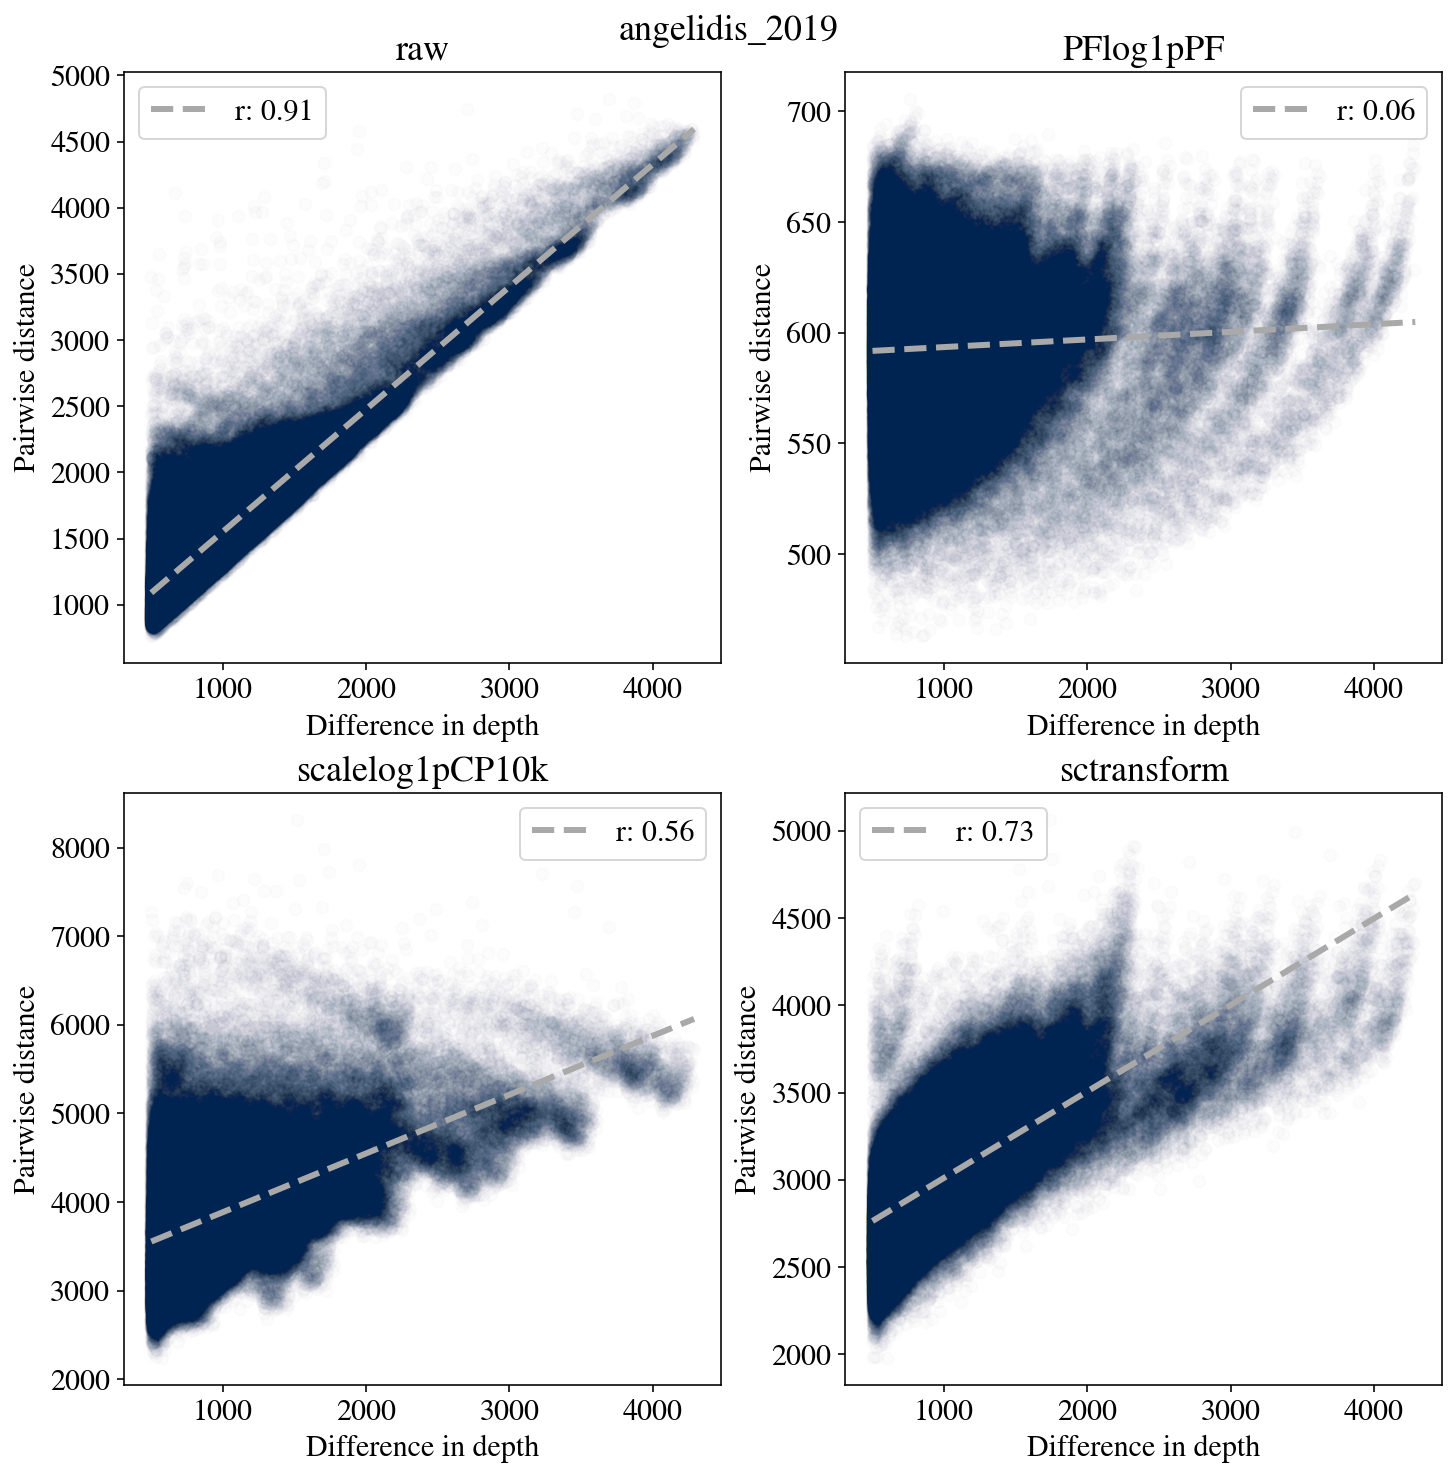

In [26]:
nc = 2
nr = 2

fig, axs = plt.subplots(
    figsize=(5 * nc, 5 * nr), nrows=nr, ncols=nc, constrained_layout=True
)
fig.suptitle(ds, y=1.01)
# fig.subplots_adjust(hspace=0.3, wspace=0.3)
for ax, l in zip(fig.axes, ["raw", "PFlog1pPF", "scalelog1pCP10k", "sctransform"]):
    x = depth[depth_mask]
    y = dist[l][depth_mask]
    r, p = stats.pearsonr(x, y)
    ax.scatter(x, y, alpha=0.01, facecolor=colors["cell"])
    reg = LinearRegression().fit(x.reshape(-1, 1), y)

    xx = np.array([min(x), max(x)])
    ax.plot(
        xx,
        reg.coef_ * xx + reg.intercept_,
        color="darkgray",
        linestyle="--",
        linewidth=3,
        label=f"r: {r:,.2f}",
    )

    ax.set(
        **{
            "xlabel": "Difference in depth",
            "ylabel": "Pairwise distance",
            "title": l,
        }
    )
    ax.legend()


# base_file_name = "angelidis_2019-pairwise_dist_depth-scatter"
# save_path = os.path.join(base_figure_path, base_file_name)
# if not os.path.exists(save_path):
#     os.makedirs(save_path)

# fig.savefig(os.path.join(save_path, f"{base_file_name}.png"), facecolor='white', transparent=False, dpi=300, bbox_inches="tight")
# fig.savefig(os.path.join(save_path, f"{base_file_name}.pdf"), dpi=300, bbox_inches="tight")

fig.show()

/home/sina/bin/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  if sys.path[0] == '':


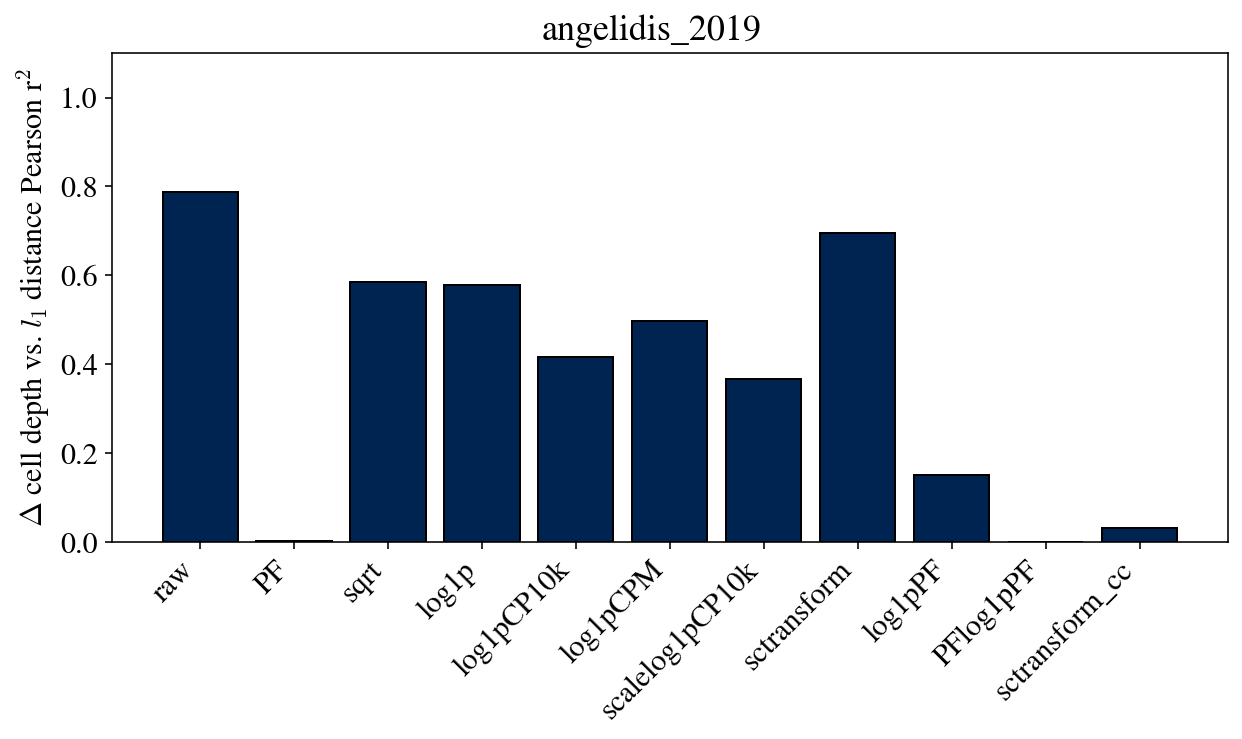

In [27]:
fig, ax = plt.subplots(figsize=(10, 4.5))
fig.suptitle(ds, y=0.94)

x = [k for k, _ in ct_metrics.items()]
y = np.array([v["depth_distance"] for k, v in ct_metrics.items()])
ax.bar(x, y ** 2, facecolor=colors["cell"], edgecolor="k")
ax.set(
    **{
        "ylabel": "$\Delta$ cell depth vs. $l_1$ distance Pearson r$^2$",
        "ylim": (0, 1.1),
    }
)
ax.set_xticklabels(x, ha="right", rotation=45)

# base_file_name = "angelidis_2019-delta_cell_depth_l1_dist_pearson-bar"
# save_path = os.path.join(base_figure_path, base_file_name)
# if not os.path.exists(save_path):
#     os.makedirs(save_path)

# fig.savefig(os.path.join(save_path, f"{base_file_name}.png"), facecolor='white', transparent=False, dpi=300, bbox_inches="tight")
# fig.savefig(os.path.join(save_path, f"{base_file_name}.pdf"), dpi=300, bbox_inches="tight")

fig.show()

# DE on highest variable cluster

In [55]:
# @title mx diff

import logging

import numpy as np
import pandas as pd
from scipy.stats import ks_2samp, ttest_ind

logger = logging.getLogger()
logger.setLevel(logging.INFO)
logging.basicConfig(format="%(asctime)s - %(message)s", datefmt="%d-%b-%y %H:%M:%S")

import numpy as np
from statsmodels.stats.multitest import multipletests


def split_by_target(mat, targets, target, axis=0):
    """
    Split the rows of mat by the proper assignment

    mat = ndarray
    targets, length is equal to number of components (axis=0) or features (axis=1)
    target is a singular element from unique(assignments/features)
    """

    if axis == 0 and len(targets) != mat.shape[axis]:
        return -1
    if axis == 1 and len(targets) != mat.shape[axis]:
        return -1

    mask = targets == target

    if axis == 0:
        t_mat = mat[mask]  # target matrix
        c_mat = mat[~mask]  # complement matrix
    elif axis == 1:
        t_mat = mat[:, mask]  # target matrix
        c_mat = mat[:, ~mask]  # complement matrix

    return (t_mat, c_mat)


def correct_pval(pval, nfeat, method):
    if method == "bonferroni":
        pval_corr = np.minimum(pval * nfeat[:, None], 1.0)
    return pval_corr


def nd(arr):
    return np.asarray(arr).reshape(-1)


def correct_pvals(pvals):
    r = np.empty(np.shape(pvals))
    r[:] = np.nan
    for pidx, p in enumerate(pvals):
        mask = ~np.isnan(p)

    return r


def dexpress(mat, components, features, assignments, **kwargs):
    """
    mat: ndarray
    components: nparray
    features: nparray
    assignments: nparray, length is equal to length of components
    """
    nan_cutoff = kwargs.get("nan_cutoff", 0)

    unique = np.unique(assignments)

    ncomp = components.shape[0]
    nfeat = features.shape[0]
    nuniq = unique.shape[0]

    pval = np.empty((nuniq, nfeat))  # unique assignments by features
    pval_corr = np.empty((nuniq, nfeat))  # unique assignments by features
    stat = np.empty((nuniq, nfeat))  # unique assignments by features
    es = np.empty((nuniq, nfeat))  # unique assignments by features
    nfeatures = np.empty((nuniq))

    pval.fill(np.nan)
    pval_corr.fill(np.nan)
    stat.fill(np.nan)
    es.fill(np.nan)
    nfeatures.fill(np.nan)

    for tidx, t in enumerate(unique):
        logging.info("{} of {} assignments: {}".format(tidx + 1, nuniq, t))

        t_mat, c_mat = split_by_target(mat, assignments, t, axis=0)

        pvalue = np.nan
        statistic = np.nan
        effect_size = np.nan

        # Keep only the genes for which it is in at least nan_cutoff*ncellsinclusters
        mask = np.asarray(
            (t_mat > 0).sum(axis=0) > nan_cutoff * t_mat.shape[0]
        ).reshape(-1)

        t_mat = t_mat[:, mask]
        c_mat = c_mat[:, mask]
        # added

        # added
        if mask.sum() > 0:
            test = ttest_ind(t_mat, c_mat, nan_policy="propagate", equal_var=False)
            pvalue = test.pvalue
            statistic = test.statistic
            effect_size = nd(t_mat.mean(axis=0)) - nd(c_mat.mean(axis=0))
            nfeatures[tidx] = mask.sum()

        pval[tidx, :][mask] = pvalue
        stat[tidx, :][mask] = statistic
        es[tidx, :][mask] = effect_size
    return (pval, stat, es, nfeatures)


def make_table(assignments, features, p_raw, p_corr, es):
    unique = np.unique(assignments)
    markers = pd.DataFrame(index=unique, columns=["name", "p_raw", "p_corr", "es"])

    for uidx, u in enumerate(unique):
        markers.loc[u]["name"] = features
        markers.loc[u]["p_raw"] = p_raw[uidx]
        markers.loc[u]["p_corr"] = p_corr[uidx]
        markers.loc[u]["es"] = es[uidx]

    markers = markers.apply(pd.Series.explode).reset_index()
    markers = markers[markers.notnull()["p_raw"]]
    markers = markers.rename(columns={"index": "group_id"})
    return markers


def diff(mat, components, features, assignments):

    unique = np.unique(assignments)
    nan_cutoff = 0.1  # of elements in cluster
    corr_method = "bonferroni"

    p_raw, stat, es, nfeat = dexpress(
        mat, components, features, assignments, nan_cutoff=nan_cutoff
    )
    p_raw = p_raw / 2
    p_corr = correct_pval(p_raw, nfeat, corr_method)

    s = stat

    markers_gene = make_table(assignments, features, p_raw, p_corr, es)

    # convert the 0 pvalues to the smallest possible float
    markers_gene["p_corr"][markers_gene.eval("p_corr == 0").values] = sys.float_info.min
    # markers_gene = markers_gene.query("es > 0")
    return markers_gene

In [56]:
cellsum = data["raw"][ct_mask].sum(1)

In [57]:
n = 1000
min_sidx, max_sidx = np.array_split(np.argsort(cellsum), 2)

# ## for truncating
min_sidx = min_sidx[500:n]
max_sidx = max_sidx[-500:]
subset_idx = np.hstack([min_sidx, max_sidx])

# # # if truncating, use stack and sidx (on rows of matrix)
stack = np.hstack([np.zeros_like(min_sidx), np.ones_like(max_sidx)])
split_ct_assignments = stack

# # if not truncating then use this
# split_ct_assignments = np.hstack([stack[min_sidx], stack[max_sidx]])

In [60]:
dfs = {}
for l in labels:
    dfs[l] = diff(
        data[l][ct_mask][subset_idx],
        bcs[ct_mask].index.values[subset_idx],
        genes,
        split_ct_assignments,
    )

17-Apr-22 19:14:02 - 1 of 2 assignments: 0
17-Apr-22 19:14:02 - 2 of 2 assignments: 1
/home/sina/bin/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:154: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
17-Apr-22 19:14:03 - 1 of 2 assignments: 0
17-Apr-22 19:14:03 - 2 of 2 assignments: 1
17-Apr-22 19:14:03 - 1 of 2 assignments: 0
17-Apr-22 19:14:03 - 2 of 2 assignments: 1
17-Apr-22 19:14:03 - 1 of 2 assignments: 0
17-Apr-22 19:14:03 - 2 of 2 assignments: 1
17-Apr-22 19:14:04 - 1 of 2 assignments: 0
17-Apr-22 19:14:04 - 2 of 2 assignments: 1
17-Apr-22 19:14:04 - 1 of 2 assignments: 0
17-Apr-22 19:14:04 - 2 of 2 assignments: 1
17-Apr-22 19:14:05 - 1 of 2 assignments: 0
17-Apr-22 19:14:05 - 2 of 2 assignments: 1
17-Apr-22 19:14:05 - 1 of 2 assignments: 0
17-Apr-22 19:14:05 - 2 of 2 assignments: 1


In [61]:
res = {}
alpha = 0.01
for l in labels:
    df = dfs[l].query(f"p_corr < {alpha}")
    res[l] = df
    ct_metrics[l]["de_genes"] = df.name.nunique()

/home/sina/bin/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  del sys.path[0]


[Text(0, 0, 'raw'),
 Text(1, 0, 'PF'),
 Text(2, 0, 'sqrt'),
 Text(3, 0, 'log1p'),
 Text(4, 0, 'log1pCP10k'),
 Text(5, 0, 'log1pCPM'),
 Text(6, 0, 'scalelog1pCP10k'),
 Text(7, 0, 'sctransform'),
 Text(8, 0, 'log1pPF'),
 Text(9, 0, 'PFlog1pPF'),
 Text(10, 0, 'log1pPFsctransform_cc')]

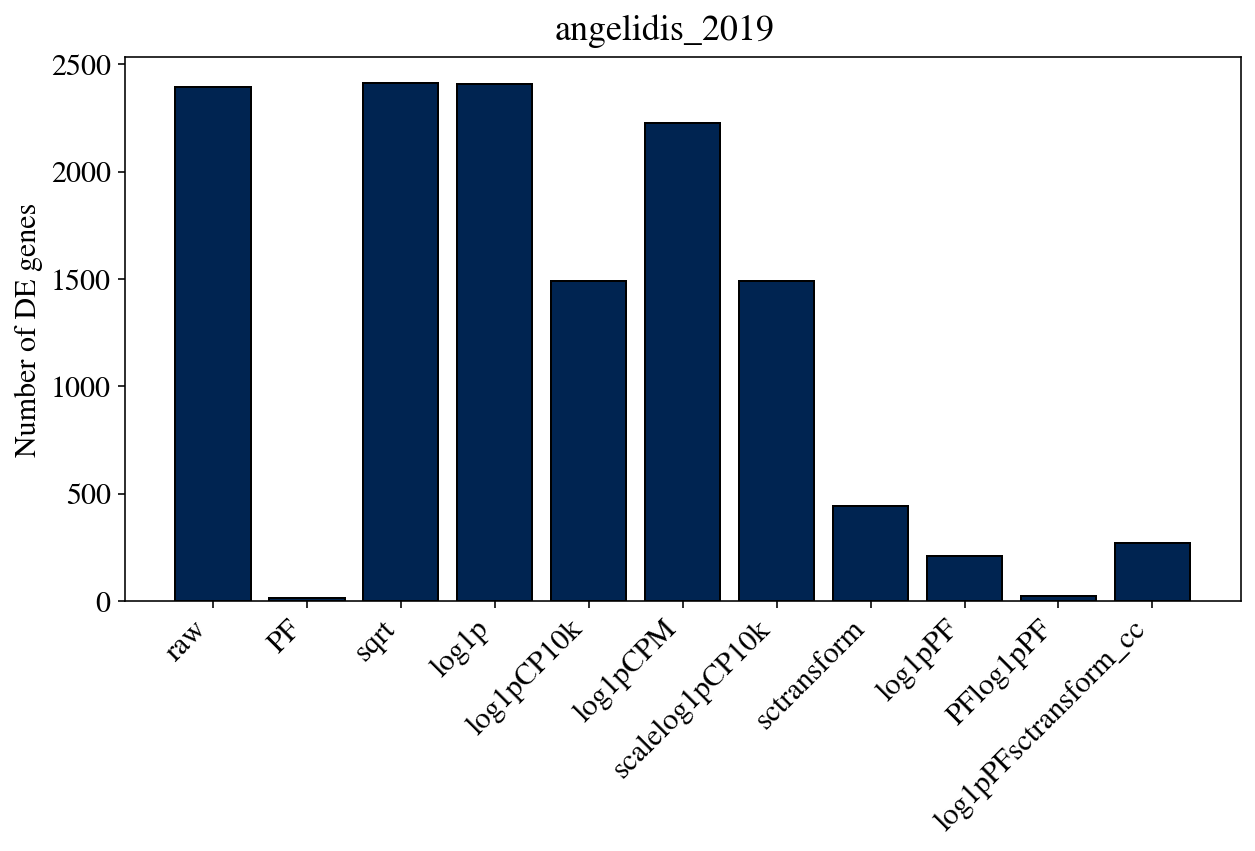

In [62]:
fig, ax = plt.subplots(figsize=(10, 5))
fig.suptitle(ds, y=0.94)

x = [k for k, _ in res.items()]
y = [v.name.nunique() for k, v in res.items()]
ax.bar(x, y, facecolor=colors["cell"], edgecolor="k")
ax.set(
    **{
        "ylabel": "Number of DE genes",
    }
)

ax.set_xticklabels(x, ha="right", rotation=45)

# base_file_name = "angelidis_2019-de_genes_celltype_split_depth-bar"
# save_path = os.path.join(base_figure_path, base_file_name)
# if not os.path.exists(save_path):
#     os.makedirs(save_path)

# fig.savefig(
#     os.path.join(save_path, f"{base_file_name}.png"),
#     facecolor="white",
#     transparent=False,
#     dpi=300,
#     bbox_inches="tight",
# )
# fig.savefig(
#     os.path.join(save_path, f"{base_file_name}.pdf"), dpi=300, bbox_inches="tight"
# )

# fig.show()

In [ ]:
# one example with corrected counts (sct and sct_cc only supp fig)

/home/sina/bin/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  if sys.path[0] == '':


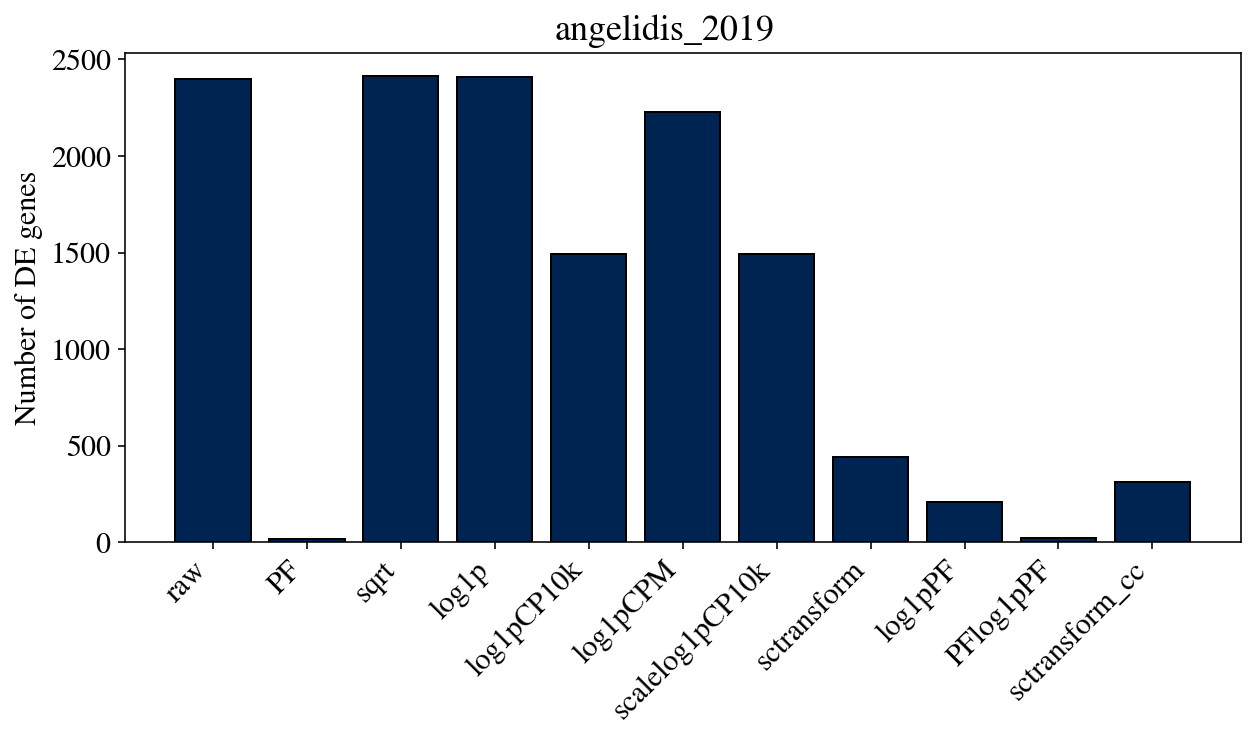

In [37]:
fig, ax = plt.subplots(figsize=(10, 4.5))
fig.suptitle(ds, y=0.94)

x = [k for k, _ in res.items()]
y = [v.name.nunique() for k, v in res.items()]
ax.bar(x, y, facecolor=colors["cell"], edgecolor="k")
ax.set(
    **{
        "ylabel": "Number of DE genes",
    }
)

ax.set_xticklabels(x, ha="right", rotation=45)

# fig.savefig(f"{ds}_depth_de_bar.png", facecolor='white', transparent=False, dpi=300, bbox_inches="tight")

fig.show()

In [69]:
ct_metrics

defaultdict(dict,
            {'raw': {'depth_distance': 0.8879854960414477,
              'de_genes': 2397,
              'r2_pc1': 0.8993352027935686},
             'PF': {'depth_distance': -0.05591480391599708,
              'de_genes': 16,
              'r2_pc1': 0.07820314771925342},
             'sqrt': {'depth_distance': 0.7643776690137498,
              'de_genes': 2412,
              'r2_pc1': 0.9153759529116909},
             'log1p': {'depth_distance': 0.7600414825050223,
              'de_genes': 2410,
              'r2_pc1': 0.9465309112166684},
             'log1pCP10k': {'depth_distance': 0.6458577872213163,
              'de_genes': 1490,
              'r2_pc1': 0.78569150398444},
             'log1pCPM': {'depth_distance': 0.7051055526292076,
              'de_genes': 2228,
              'r2_pc1': 0.9092972342294078},
             'scalelog1pCP10k': {'depth_distance': 0.6065288648407331,
              'de_genes': 1490,
              'r2_pc1': 0.8424593677240342},
     